In [1]:
#import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [2]:
#%lsmagic

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

import random
import tensorflow_addons as tfa
import math

from tensorflow.keras import layers
start = dt.datetime.now()

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
  except RuntimeError as e:
    print(e)

In [3]:
DP_DIR = 'D:/Desktop/shuffle-csvs/'
INPUT_DIR = 'D:/Desktop/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.random.set_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [64]:
print(list_all_categories())
for i in (list_all_categories()):
    print (i)

['airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 'donut', 'door', 'dr

In [4]:
cats = list_all_categories()

In [75]:
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
  
# How many elements each 
# list should have 
n = 34
  

In [5]:
for v in (cats):
    print(v)

airplane
alarm clock
ambulance
angel
animal migration
ant
anvil
apple
arm
asparagus
axe
backpack
banana
bandage
barn
baseball
baseball bat
basket
basketball
bat
bathtub
beach
bear
beard
bed
bee
belt
bench
bicycle
binoculars
bird
birthday cake
blackberry
blueberry
book
boomerang
bottlecap
bowtie
bracelet
brain
bread
bridge
broccoli
broom
bucket
bulldozer
bus
bush
butterfly
cactus
cake
calculator
calendar
camel
camera
camouflage
campfire
candle
cannon
canoe
car
carrot
castle
cat
ceiling fan
cell phone
cello
chair
chandelier
church
circle
clarinet
clock
cloud
coffee cup
compass
computer
cookie
cooler
couch
cow
crab
crayon
crocodile
crown
cruise ship
cup
diamond
dishwasher
diving board
dog
dolphin
donut
door
dragon
dresser
drill
drums
duck
dumbbell
ear
elbow
elephant
envelope
eraser
eye
eyeglasses
face
fan
feather
fence
finger
fire hydrant
fireplace
firetruck
fish
flamingo
flashlight
flip flops
floor lamp
flower
flying saucer
foot
fork
frog
frying pan
garden
garden hose
giraffe
goatee
golf

In [4]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)


MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications


In [5]:
STEPS = 10000
EPOCHS = 100
size = 64
batchsize = 980

In [10]:
def toy_resnet(input_shape=(size, size, 1), classes=NCATS):
    
    inputs = keras.Input(shape=(64, 64, 1), name="img")
    
    x = layers.ZeroPadding2D((3,3))(inputs)
    
    #---------
    x = layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    
    #---------conv 1 a
    x_1 = x
    x = layers.Conv2D(64, (1, 1), strides = (2,2))(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x_1 = layers.Conv2D(256, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(x_1)
    x_1 = layers.BatchNormalization(axis=3)(x_1)
    
    #=========
    x = Add()([x,x_1])
    x = Activation('elu')(x)    
    
     
    #---------id 1 a
    x_2 = x
    x = layers.Conv2D(64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_2])
    x = Activation('elu')(x)
    
    #---------id 2 a
    x_3 = x
    x = layers.Conv2D(64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
        
    #=========
    x = Add()([x,x_3])
    x = Activation('elu')(x)
    
    
    #---------conv 1 b
    x_4 = x
    x = layers.Conv2D(128, (1, 1), strides = (2,2))(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x_4 = layers.Conv2D(512, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(x_4)
    x_4 = layers.BatchNormalization(axis=3)(x_4)
    
    #=========
    x = Add()([x,x_4])
    x = Activation('elu')(x)    
    
    
    #---------id 1 b
    x_5 = x
    x = layers.Conv2D(128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_5])
    x = Activation('elu')(x) 
    
    
    #---------id 2 b
    x_6 = x
    x = layers.Conv2D(128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_6])
    x = Activation('elu')(x) 
    
    
    #---------id 2 c
    x_7 = x
    x = layers.Conv2D(128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_7])
    x = Activation('elu')(x) 
    
    
    #---------
    x = layers.AveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = Dense(NCATS, activation = 'softmax')(x)
    
    model = keras.Model(inputs, x, name="toy_resnet")
    
    return model

In [11]:
model = toy_resnet(input_shape=(size, size, 1), classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           img[0][0]                        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
_________________________________________________________________________________________

Training with Image Generator

In [6]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    r = random.randint(0,19)
                    if(r == 1):
                        r1 = random.randint(0,len(raw_strokes)-1)
                        r2 = random.randint(0,len(raw_strokes[r1][0])-1)
                        r3 = random.randint(0,len(raw_strokes[r1][1])-1)
                        raw_strokes[r1][0][r2] = random.randint(0,256)
                        raw_strokes[r1][1][r3] = random.randint(0,256)                    
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                    r = random.randint(0,19)
                    if(r == 1):
                        x[i, :, :, 0] = tfa.image.rotate(x[i, :, :, 0], random.randint(-30,30) * math.pi / 180, interpolation='BILINEAR')
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [32]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [34]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

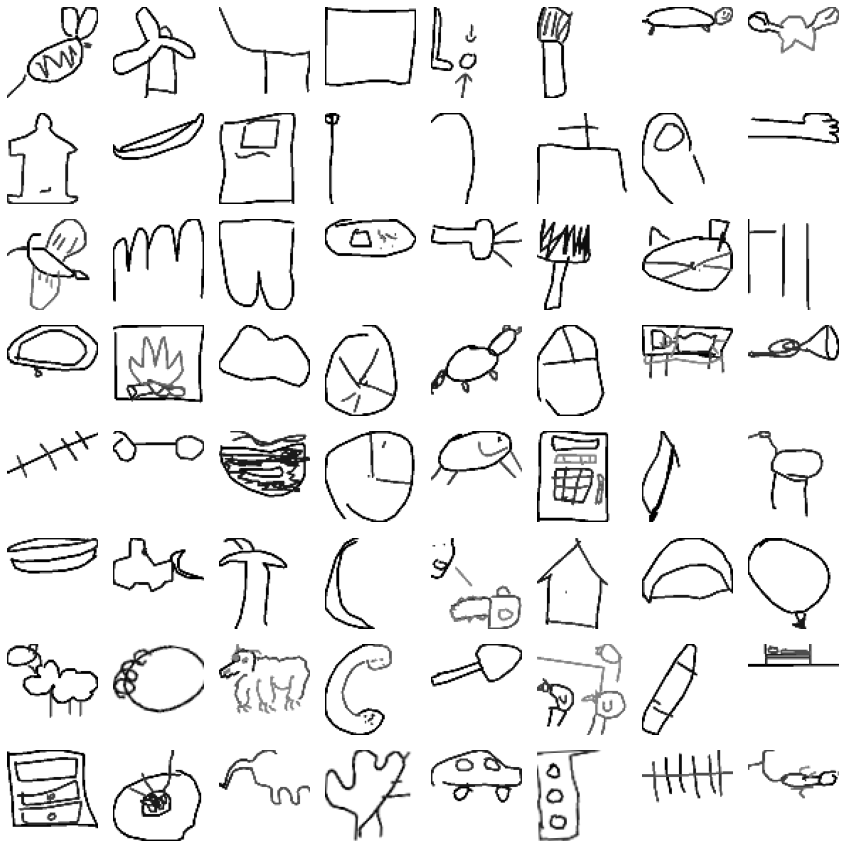

In [35]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [36]:
%%timeit
x, y = next(train_datagen)

254 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('modelelperepoch.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=False),
    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=False)

]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=100, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
10000/10000 [==============================] - 4368s 437ms/step - loss: 1.3466 - categorical_crossentropy: 1.3466 - categorical_accuracy: 0.6702 - top_3_accuracy: 0.8386 - val_loss: 1.1290 - val_categorical_crossentropy: 1.1290 - val_categorical_accuracy: 0.7151 - val_top_3_accuracy: 0.8739
Epoch 2/100
10000/10000 [==============================] - 4281s 428ms/step - loss: 1.0561 - categorical_crossentropy: 1.0561 - categorical_accuracy: 0.7330 - top_3_accuracy: 0.8844 - val_loss: 1.0217 - val_categorical_crossentropy: 1.0217 - val_categorical_accuracy: 0.7426 - val_top_3_accuracy: 0.8908
Epoch 3/100
10000/10000 [==============================] - 4077s 408ms/step - loss: 0.9804 - categorical_crossentropy: 0.9804 - categorical_accuracy: 0.7503 - top_3_accuracy: 0.8951 - val_loss: 0.9635 - val_categorical_crossentropy: 0.9635 - val_categorical_accuracy: 0.7549 - val_top_3_accuracy: 0.8976
Epoch 4/100


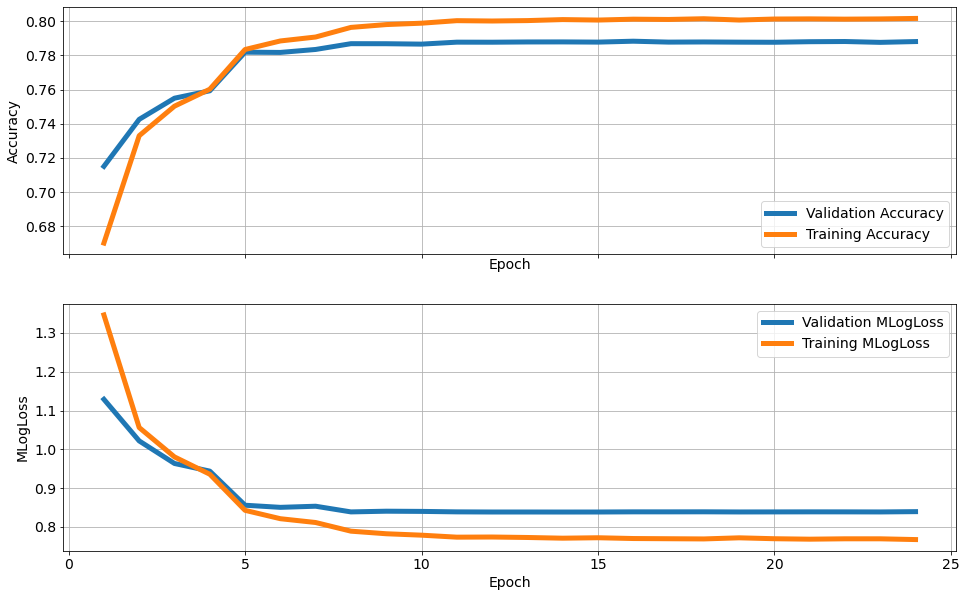

In [16]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [37]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

266/266 [==============================] - 3s 10ms/step
Map3: 0.843


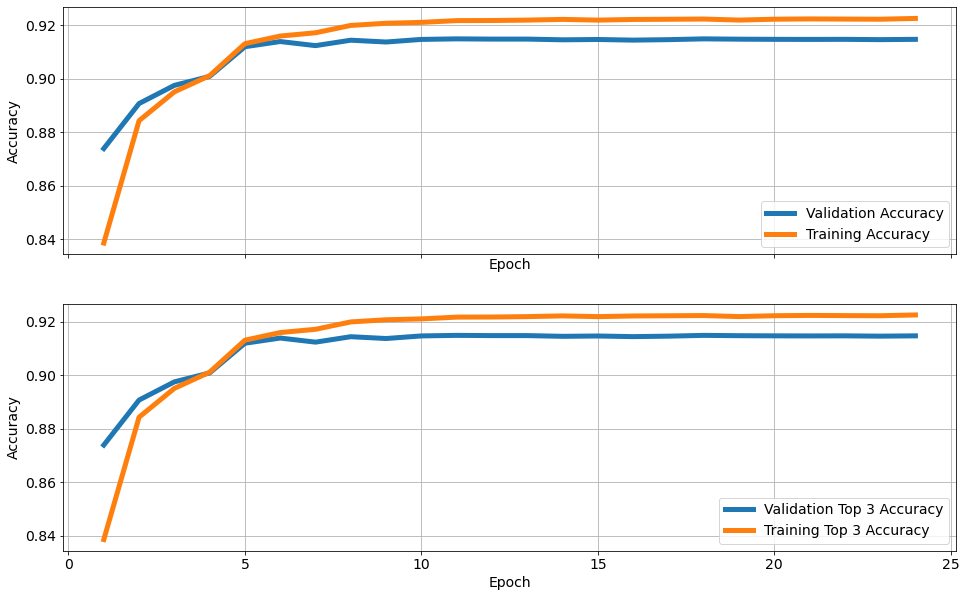

In [34]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_top_3_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.top_3_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_top_3_accuracy, lw=5, label='Validation Top 3 Accuracy')
axs[1].plot(hist_df.top_3_accuracy, lw=5, label='Training Top 3 Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();


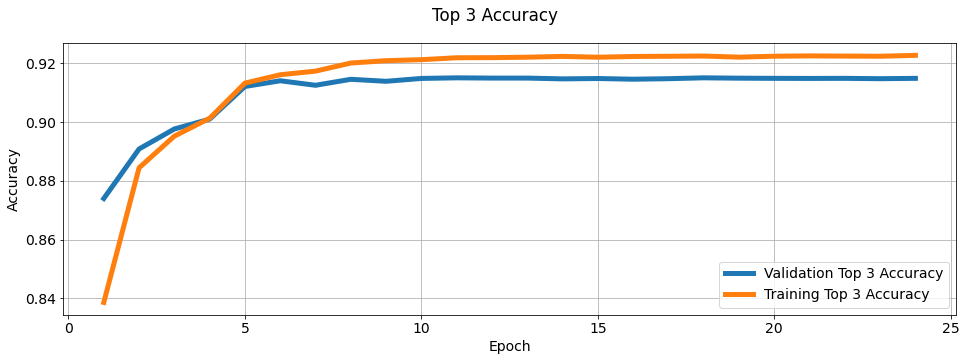

In [35]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
plt.figure(figsize=(16, 5))
plt.plot(hist_df.val_top_3_accuracy, lw=5, label='Validation Top 3 Accuracy')
plt.plot(hist_df.top_3_accuracy, lw=5, label='Training Top 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc=0)
plt.suptitle('Top 3 Accuracy')
fig.savefig('hist.png', dpi=300)
plt.show();

In [7]:
new_model = tf.keras.models.load_model('modelelperepoch.h5', compile = False)
new_model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
# Checak its architecture
new_model.summary()


Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           img[0][0]                        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
_________________________________________________________________________________________

In [8]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'all/test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [28]:
test_predictions = new_model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

877/877 [==============================] - 8s 10ms/step


,a,b,c
0,234,281,266
1,144,36,125
2,305,62,110
3,187,303,304
4,56,113,165


(112199, 3)

,a,b,c
0,radio,stereo,snorkel
1,hockey_puck,bottlecap,frying_pan
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,The_Eiffel_Tower
4,campfire,fireplace,leaf


(112199, 3)

In [38]:

test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo snorkel
1,9000010688666847,hockey_puck bottlecap frying_pan
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent The_Eiffel_Tower
4,9000052667981386,campfire fireplace leaf


(112199, 2)

In [42]:
test_predictions = new_model.predict(x_valid, batch_size=128, verbose=1)

266/266 [==============================] - 3s 10ms/step


In [46]:
rtest_predictions = np.argmax(test_predictions, axis=-1)
print (rtest_predictions)
for i in  rtest_predictions:
    print (i)

[ 22  30 123 ...  87  12  53]
22
30
123
156
108
107
83
136
104
70
128
112
111
131
148
214
115
50
119
314
264
8
45
67
94
211
254
84
251
225
154
170
333
245
54
163
76
240
9
103
161
113
301
248
151
15
338
110
185
60
22
40
215
251
204
237
266
308
144
148
159
225
225
55
32
84
36
262
306
161
159
311
129
327
39
19
318
44
10
81
135
91
318
95
142
60
160
182
140
4
280
29
24
262
153
77
334
74
299
205
114
196
242
86
84
163
60
317
245
233
186
123
137
169
11
297
336
120
278
308
177
305
235
102
323
16
335
338
7
89
200
115
131
75
100
113
336
249
273
104
73
89
130
279
59
298
258
2
273
66
59
145
1
252
265
98
117
256
254
88
241
304
264
48
194
138
316
107
304
264
264
48
121
226
105
330
285
143
8
261
50
303
254
26
43
116
240
166
31
82
312
120
97
238
183
317
187
280
25
293
24
333
76
101
240
275
296
248
101
166
164
157
280
318
296
260
304
334
116
160
316
171
120
153
61
138
12
75
85
91
46
264
246
71
11
302
208
239
327
3
177
296
189
251
196
7
248
330
228
90
80
46
37
309
284
334
168
264
26
172
108
283
125
116
1

In [ ]:

for i in  rtest_predictions:
    print (i)

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

In [44]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
cm = confusion_matrix(y_true=y_valid, y_pred=rtest_predictions)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [21]:
test_labels = np.array(list_all_categories())
print(test_labels)

['airplane' 'alarm clock' 'ambulance' 'angel' 'animal migration' 'ant'
 'anvil' 'apple' 'arm' 'asparagus' 'axe' 'backpack' 'banana' 'bandage'
 'barn' 'baseball' 'baseball bat' 'basket' 'basketball' 'bat' 'bathtub'
 'beach' 'bear' 'beard' 'bed' 'bee' 'belt' 'bench' 'bicycle' 'binoculars'
 'bird' 'birthday cake' 'blackberry' 'blueberry' 'book' 'boomerang'
 'bottlecap' 'bowtie' 'bracelet' 'brain' 'bread' 'bridge' 'broccoli'
 'broom' 'bucket' 'bulldozer' 'bus' 'bush' 'butterfly' 'cactus' 'cake'
 'calculator' 'calendar' 'camel' 'camera' 'camouflage' 'campfire' 'candle'
 'cannon' 'canoe' 'car' 'carrot' 'castle' 'cat' 'ceiling fan' 'cell phone'
 'cello' 'chair' 'chandelier' 'church' 'circle' 'clarinet' 'clock' 'cloud'
 'coffee cup' 'compass' 'computer' 'cookie' 'cooler' 'couch' 'cow' 'crab'
 'crayon' 'crocodile' 'crown' 'cruise ship' 'cup' 'diamond' 'dishwasher'
 'diving board' 'dog' 'dolphin' 'donut' 'door' 'dragon' 'dresser' 'drill'
 'drums' 'duck' 'dumbbell' 'ear' 'elbow' 'elephant' 'envel

In [41]:
keras.utils.plot_model(new_model, "modelplot.png", show_shapes = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
